In [1]:
import matplotlib.pyplot as plt
import numpy as np

#import pandas as pd
import os 

import h5py
import json
import random
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

resize_transform = transforms.Resize( (256, 128) )
inverse_resize_transform = transforms.Resize( (201, 101) )

if(torch.cuda.is_available()):
    count = torch.cuda.device_count();
    print("CUDA is available and can be used by", count, "device(s).");
    curr_device =  torch.cuda.current_device();
    for i in range(count):
        curr_device_name = torch.cuda.get_device_name(i);
        print("Device",curr_device, ", referring to the GPU", curr_device_name, ", is in use by torch");
        
else:
    print("CUDA is unavailable");

CUDA is available and can be used by 4 device(s).
Device 0 , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch
Device 0 , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch
Device 0 , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch
Device 0 , referring to the GPU NVIDIA A100-SXM4-40GB , is in use by torch


In [2]:
tracking_results_direc = '/global/cfs/cdirs/m669/riverr/2DCSR/results_lucretia_beams/' ## directory containing CSR wakefields 
vary_s_results_direc = '/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/'
beam_direc= '/global/cfs/cdirs/m669/riverr/2DCSR/lucretia_beams/' ## directory containing beams used to calculate CSR wakefields 

In [3]:
def load_step(file, n_step, directory = tracking_results_direc, emit = False): # load one step from a simulation file 
    file_name = directory + f'/{file}';#f'2DCSR_NN_lucretia/{file}'
    #print(file_name)
    h5 = h5py.File(file_name, 'r');
    result = h5['csr_result'];
    #print(result.keys())
    nz, nx = result["Ws_grid_list"][n_step].T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = result["lambda_grid_list"][n_step].T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    zmin = result["zmin_list"][n_step]; ## minimum z coordinate
    zmax = result["zmax_list"][n_step];
    xmin = result["xmin_list"][n_step];
    xmax = result["xmax_list"][n_step];

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = result["Ws_grid_list"][n_step].T;
    Wx_grid = result["Wx_grid_list"][n_step].T;
    lambda_grid = result["lambda_grid_list"][n_step].T;

    s = np.array(result["s_at_kick_list"])[n_step];
    if emit:
        epsx = np.array(result["emit_at_kick_list"])[n_step];
        epsx_0 = np.array(result["emit_disp_free_at_kick_list"])[n_step];
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s, epsx, epsx_0 ;
    else:
        
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s;

## Here we will choose the phases we exclude from training

In [4]:
L2_phases = []
for j, file in enumerate(os.listdir(tracking_results_direc)):
    if file.startswith('result'):
        ind_0 = file.find("P2");
        ind_1 = file.find(".h");
        L2_phase = file[ind_0+3: ind_1];
        L2_phases.append(float(L2_phase));
L2_phases.sort()

excluded_phases = [L2_phases[i] for i in range(2,5)];
excluded_phases += ([L2_phases[i] for i in range(-3,0)]);   
excluded_phases;

In [5]:
%%time

ns = np.arange(20) # 20 steps per simulation 

for j, file in enumerate(os.listdir(tracking_results_direc)):
    if file.startswith('result'):
        ind_0 = file.find("P2");
        ind_1 = file.find(".h");
        L2_phase = float(file[ind_0+3: ind_1]);
        if(L2_phase in excluded_phases):
            print("Not training on ", L2_phase);
            continue;
        else:
            pass;
            #print(f"Loading {L2_phase}");
        for i, n in enumerate(ns):
            xv, zv, Ws, Wx, rho, s = load_step(file, n)
            Ws = Ws[:-1,:-1]
            Wx = Wx[:-1,:-1]
            rho = rho[:]

            dx = np.mean(np.diff(xv))
            dz = np.mean(np.diff(zv))

            if (i == 0) & (j == 0):
                Ws_data = [Ws]
                Wx_data = [Wx]
                rho_data = [rho*dx*dz] ## note: rho is normalized to have sum of unity 
                dx_data = [dx]
                dz_data = [dz]
                s_data = [s]
            else:
                Ws_data = np.concatenate(([Ws], Ws_data))
                Wx_data = np.concatenate(([Wx], Wx_data))
                rho_data = np.concatenate(([rho*dx*dz], rho_data)) ## note: rho is normalized to have sum of unity 
                dx_data = np.concatenate(([dx], dx_data))
                dz_data = np.concatenate(([dz], dz_data))
                s_data = np.concatenate(([s], s_data))
                
print("Done loading in data");


### NOTE: resize_transform does not preserve the sum of the arrays over the grid. Thus we multiply by (100*200/(256*128))                
## when we resize back later on, we should multiply by the inverse factor 
fac = 100*200/(256*128);

Ws_data = torch.tensor(Ws_data)
Ws_data = fac*resize_transform(Ws_data)
Ws_data = torch.unsqueeze(Ws_data, dim=1)

Wx_data = torch.tensor(Wx_data)
Wx_data = fac*resize_transform(Wx_data)
Wx_data = torch.unsqueeze(Wx_data, dim=1)

rho_data = torch.tensor(rho_data)
rho_data = fac*resize_transform(rho_data)
rho_data = torch.unsqueeze(rho_data, dim=1)

dx_data = torch.tensor(dx_data)
dx_data = torch.unsqueeze(dx_data, dim=1)
dz_data = torch.tensor(dz_data)
dz_data = torch.unsqueeze(dz_data, dim=1)
s_data = torch.tensor(s_data)
s_data = torch.unsqueeze(s_data, dim=1)

Ws_norm = torch.max(Ws_data)
Wx_norm = torch.max(Wx_data)
s_norm = torch.max(s_data)
dz_norm = torch.max(dz_data)
dx_norm = torch.max(dx_data)

Ws_data /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_data /= Wx_norm ## normalize to maximum Wx in dataset
s_data /= s_norm ## normalize to maximum s in dataset 
dz_data /= dz_norm ## normalize dz to maximum dz in dataset 
dx_data /= dx_norm


#Save somewhere safe
basedir = 'global/homes/o/ocamacho/2DCSR_from_home/saved_networks/';
normalizations = {"Ws_norm" : float(Ws_norm), "Wx_norm" : float(Wx_norm), "s_norm" : float(s_norm), "dz_norm" : float(dz_norm), "dx_norm" : float(dx_norm) };
normalizations_filename = basedir +"normalizations_04-30-24_2.txt"

with open(normalizations_filename, 'w') as file:
        json.dump(normalizations, file)
print("Successfully saved our normalizations")



Ws_data = Ws_data.to(torch.float32)
Wx_data = Wx_data.to(torch.float32)
rho_data = rho_data.to(torch.float32)
s_data = s_data.to(torch.float32)
dz_data = dz_data.to(torch.float32)
dx_data = dx_data.to(torch.float32)


Not training on  -38.9
Not training on  -38.95
Not training on  -37.55
Not training on  -37.525
Not training on  -38.925
Not training on  -37.5
Done loading in data
Successfully saved our normalizations


NameError: name 'Ws_test' is not defined

In [25]:

## two-dimensional W array 
W_data = torch.cat((Ws_data, Wx_data), dim=1);
scalar_data = torch.cat((s_data,dx_data,dz_data), dim=1);

In [ ]:
basedir = 'global/homes/o/ocamacho/2DCSR_from_home/saved_networks/'
norm_file = 'normalizations_04-30-2023-500_epochs.h5'

with h5py.File(f'{basedir}/{norm_file}', 'r') as f:
    Ws_norm = f['Ws_norm']
    Wx_norm = f['Wx_norm']
    dx_norm = f['dx_norm']
    dz_norm = f['dz_norm']
    s_norm = f['s_norm']

In [12]:
def load_step_s_check(file, directory = '/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/', emit = False): # load one step from a simulation file 
    file_name = directory + f'/{file}';#f'2DCSR_NN_lucretia/{file}'
    #print(file_name)
    h5 = h5py.File(file_name, 'r');

    result = h5['csr_result'];
    
    #print(result.keys())
    nz, nx = np.array(result["Ws_grid"]).T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = np.array(result["lambda_grid"]).T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    if 'zv' in result.keys():
        zmin = min(result["zv"]); ## minimum z coordinate
        zmax = max(result["zv"]);
    else:
        zmin = min(result["zmin"]); ## minimum z coordinate
        zmax = max(result["zmin"]);
    xmin = min(result["xv"]);
    xmax = max(result["xv"]);

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = np.array(result["Ws_grid"]).T;
    Wx_grid = np.array(result["Wx_grid"]).T;
    lambda_grid = np.array(result["lambda_grid"]).T;
        
    s = float( file.split('_')[-1].split('.h5')[0] )
    
    return xv, zv, Ws_grid, Wx_grid, lambda_grid, s;

In [13]:
for j, file in enumerate(os.listdir('/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/')):
    if file.startswith('result'):
        #print(file)
        xv, zv, Ws, Wx, rho, s = load_step_s_check(file)
        Ws = Ws[:-1,:-1]
        Wx = Wx[:-1,:-1]
        rho = rho[:]

        dx = np.mean(np.diff(xv))
        dz = np.mean(np.diff(zv))

        #s = float(file[-6:-3])

        Ws_data = np.concatenate(([Ws], Ws_data))
        Wx_data = np.concatenate(([Wx], Wx_data))
        rho_data = np.concatenate(([rho*dx*dz], rho_data)) ## note: rho is normalized to have sum of unity 
        dx_data = np.concatenate(([dx], dx_data))
        dz_data = np.concatenate(([dz], dz_data))
        s_data = np.concatenate(([s], s_data))
print("Done saving s dependence")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

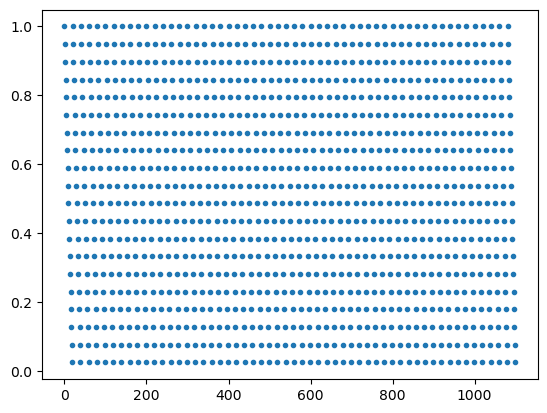

In [20]:
plt.plot(s_data, '.')

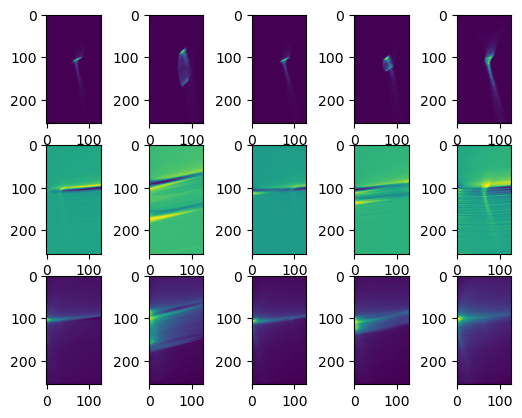

In [21]:
nshow = 5
fig, ax = plt.subplots(3, nshow)
indices = np.random.randint(0, rho_data.shape[0], nshow)
for j in range(ax.shape[1]):
    ax[0,j].imshow(rho_data[indices[j],0])
    ax[1,j].imshow(Ws_data[indices[j],0])
    ax[2,j].imshow(Wx_data[indices[j],0])

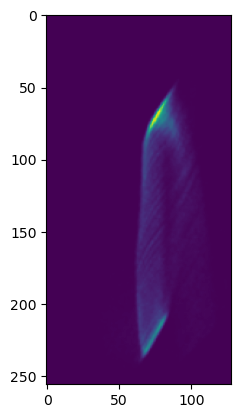

In [22]:
plt.imshow(rho_data[0, 0])

## Currently I have all of the data in rho_data, Ws_data, Wx_data, dx_data, dz_data, s_data. 
## Now I need to split into training and validation

In [23]:
print(Ws_data.shape)

torch.Size([1100, 1, 256, 128])


In [26]:
# Split up into training, validation, and testing batches
n_total = Ws_data.shape[0]
print(f"Starting with {n_total} pieces of data");
train_frac = 0.90 #approximate ercentage of data to be used for training
val_frac = 0.10;#for validation
assert train_frac + val_frac == 1.0

n_train = int(train_frac * n_total); #Training set size
train_idx = random.sample(range(n_total), n_train)
print(len(train_idx), "training examples");


remaining_idx = [i for i in range(n_total) if i not in train_idx] # remaining indices available
n_remaining = len(remaining_idx);

n_val = n_remaining
val_idx  = [ind for ind in remaining_idx];
assert n_val == len(val_idx)
print(len(val_idx), "validation examples");


W_train = W_data[train_idx];
W_val = W_data[val_idx];



rho_train = rho_data[train_idx];
rho_val = rho_data[val_idx];

scalar_train = scalar_data[train_idx];
scalar_val = scalar_data[val_idx];


Starting with 1100 pieces of data
990 training examples
110 validation examples


In [29]:
#Make sure the sets we created are pairwise disjoint!
train_idx_set = set(); val_idx_set = set(); test_idx_set = set();
for entry in train_idx:
    train_idx_set.add(entry);
for entry in val_idx:
    val_idx_set.add(entry);
pairwise_disjoint = train_idx_set.intersection(val_idx_set)  == set() and val_idx_set.intersection(test_idx_set) == set()
assert pairwise_disjoint

In [30]:
#Save somewhere safe
data_partition = {"train_idx": train_idx, "val_idx": val_idx, 'exluded_phases': excluded_phases};
data_partition_filename = "data_partition_04-30-24_500_epochs.txt"


with open(data_partition_filename, 'w') as file:
        json.dump(data_partition, file)
print("Successfully saved our partition")

Successfully saved our partition


## Define the CSR2D pytorch module

In [31]:
class CSR2D(nn.Module):
    def __init__(self):
        super(CSR2D, self).__init__()

        encoding_dim = 16 # length of 1D beam density image representation
        
        num_conv = 5 # number of convolutional layers in encoder
        nfilters = 32 # number of "matrices" in a single convolutional layer 
        kernel_sizes = (3, 7) # each size is the size of one side of the convolution matrix, we are applying two matrices here 
        pool_size = 2 # factor by which we reduce the image size on each conv layer 
        activation = nn.ReLU() # activation function for the conv layers
        
        encoder_layers = []
        
        for i in range(num_conv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0):
                    encoder_layers.append(nn.Conv2d(1, nfilters, kernel_size, padding=kernel_size//2))
                else:
                    encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding=kernel_size//2))
                encoder_layers.append(nn.BatchNorm2d(nfilters))
                encoder_layers.append(activation)
            #encoder_layers.append(nn.BatchNorm2d(nfilters))
            encoder_layers.append(nn.MaxPool2d(pool_size))
        
        encoder_layers.append(nn.Flatten())
        encoder_layers.append(nn.Linear(int(nfilters * 256/2**num_conv * 128/2**num_conv), encoding_dim))
        encoder_layers.append(activation)
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        num_dense = 2 # number of dense layers before the resizing dense layer  
        small_dim_power2 = 4 # size of image output from dense network is 2**(this) x 2**(this+1)
        num_units = 200 # number of nodes in intermediate dense layers 
        activation = nn.ReLU()
        
        dense_layers = []
        
        dense_layers.append(nn.Linear(encoding_dim + 3, num_units)) ## encoding_dim + number of scalar parameters 
        dense_layers.append(activation)
        
        for _ in range(num_dense - 1):
            dense_layers.append(nn.Linear(num_units, num_units))
            dense_layers.append(activation)
        
        dense_layers.append(nn.Linear(num_units, 2**(2*small_dim_power2+1)))
        dense_layers.append(activation)
        dense_layers.append(nn.Unflatten(1, (1,2*2**small_dim_power2, 2**small_dim_power2) )   );

        self.intermediate = nn.Sequential(*dense_layers)
        
        decoder_layers = []
        num_deconv = 7 - small_dim_power2
        
        nfilters = 32
        kernel_sizes = [3, 7]
        pool_size = 2
        activation = nn.ReLU()
        
        for i in range(num_deconv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0): 
                    decoder_layers.append(nn.ConvTranspose2d(1, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                else:
                    decoder_layers.append(nn.ConvTranspose2d(nfilters, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                decoder_layers.append(nn.BatchNorm2d(nfilters))
                decoder_layers.append(activation)
            #decoder_layers.append(nn.BatchNorm2d(nfilters))
            decoder_layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
        
        decoder_layers.append(nn.Conv2d(nfilters, 2, kernel_size=1, padding=0)) # linear activation is necessary if our network needs to give negative numbers
        
        self.decoder = nn.Sequential(*decoder_layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, img_inputs):
        scalar_inputs = img_inputs[1]
        img_inputs = img_inputs[0]
        encoded_flattened = self.encoder(img_inputs)
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        afterNN = self.intermediate(concatenated)
        decoded = self.decoder(afterNN) # Reshape to match the input size of decoder
        return decoded

In [32]:
training_dataset = TensorDataset(rho_train, scalar_train, W_train)
training_dataloader = DataLoader(training_dataset, batch_size= 64, shuffle=True)#.cuda()

## Now let's do training on the GPU 

In [33]:
#csr2d_model.to(curr_device); ## the model now lives on the GPU 
curr_device = torch.device("cuda:0")
csr2d_model = CSR2D()
"""#TODO: Put model on multiple GPUs!
csr2d_model = csr2d_model #Model(input_size, output_size)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    csr2d_model = nn.DataParallel(csr2d_model)
"""
csr2d_model.to(curr_device);

In [34]:
#csr2d_model.load_state_dict(torch.load('good_state_04-22-2024'))

In [35]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(csr2d_model.parameters(), lr=0.003)

from torch.optim.lr_scheduler import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=40, min_lr=1e-6)

In [ ]:
%%time

# Training loop
num_epochs = 500
epoch_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
for epoch in range(num_epochs):
    csr2d_model.train()  # Set model to training mode
    running_loss = 0.0
    
    for rho_input, scalar_input, W_input in training_dataloader:
        rho_input, scalar_input, W_input = rho_input.to(curr_device), scalar_input.to(curr_device), W_input.to(curr_device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = csr2d_model([rho_input, scalar_input])
        loss = criterion(outputs, W_input)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * rho_input.size(0)
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(training_dataloader.dataset)
    epoch_losses[epoch] = epoch_loss 
    
    csr2d_model.eval()
    with torch.no_grad():
        val_result = csr2d_model([rho_val.to(curr_device), scalar_val.to(curr_device)])
        val_loss = criterion(val_result, W_val.to(curr_device))
        val_losses[epoch] = val_loss
    
    if(not (epoch%10) ):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]}')
    
    reduce_lr.step(val_loss)
    
plt.plot(epoch_losses)
plt.plot(val_losses)

Epoch [1/500], Loss: 0.1349, Val Loss: 0.0559, LR: 0.003
Epoch [11/500], Loss: 0.0373, Val Loss: 0.0590, LR: 0.003
Epoch [21/500], Loss: 0.0334, Val Loss: 0.0460, LR: 0.003
Epoch [31/500], Loss: 0.0282, Val Loss: 0.0609, LR: 0.003
Epoch [41/500], Loss: 0.0246, Val Loss: 0.0487, LR: 0.003
Epoch [51/500], Loss: 0.0223, Val Loss: 0.0579, LR: 0.003
Epoch [61/500], Loss: 0.0200, Val Loss: 0.0480, LR: 0.0015
Epoch [71/500], Loss: 0.0195, Val Loss: 0.0533, LR: 0.0015
Epoch [81/500], Loss: 0.0189, Val Loss: 0.0453, LR: 0.0015
Epoch [91/500], Loss: 0.0177, Val Loss: 0.0547, LR: 0.0015
Epoch [101/500], Loss: 0.0166, Val Loss: 0.0546, LR: 0.0015
Epoch [111/500], Loss: 0.0149, Val Loss: 0.0540, LR: 0.00075
Epoch [121/500], Loss: 0.0146, Val Loss: 0.0488, LR: 0.00075
Epoch [131/500], Loss: 0.0137, Val Loss: 0.0587, LR: 0.00075
Epoch [141/500], Loss: 0.0140, Val Loss: 0.0499, LR: 0.00075
Epoch [151/500], Loss: 0.0136, Val Loss: 0.0487, LR: 0.00075
Epoch [161/500], Loss: 0.0130, Val Loss: 0.0460, LR:

In [ ]:
plt.plot(epoch_losses, label = "Training", linewidth = 1)
#plt.scatter(range(len(epoch_losses)), epoch_losses, label = "Training", s = 1)
plt.ylim(0, 0.25)
plt.xlim(-4, len(val_losses))
plt.plot(val_losses, label = "Validation", linewidth = 3/4)
#plt.scatter(range(len(val_losses)), val_losses, label = "Validation", s = 1)
plt.xlabel("Epoch")
plt.ylabel(r"$L_1$-Loss")
plt.legend();

In [ ]:
csr2d_model.eval()
result_val = csr2d_model([rho_val.to(curr_device), scalar_val.to(curr_device)])

In [ ]:
i = -3

fig, ax = plt.subplots(2,3, figsize=(8, 8))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_val[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_val[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')

ax[0,1].imshow(W_val[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_val[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')
ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')

ax[0,2].imshow(rho_val[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[1,2].imshow(rho_val[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[0,2].set_title("Beam density")


fig.suptitle(f"Performance on Testing Piece {i}", fontsize=12)
fig.tight_layout()

err1 =  np.sqrt( (criterion(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
err2 =  np.sqrt( (criterion2(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( result_test[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( result_test[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {err1:.3f}")
print(f"L_2-error is {err2:.3f}")

## Now we construct the data for the test set

In [ ]:
#%%time

ns = np.arange(20) # 20 steps per simulation 
Ws_test = []
Wx_test = []
rho_test = [] ## note: rho is normalized to have sum of unity 
dx_test = []
dz_test = []
s_test = []
for j, file in enumerate(os.listdir(tracking_results_direc)):
    if file.startswith('result'):
        ind_0 = file.find("P2");
        ind_1 = file.find(".h");
        L2_phase = float(file[ind_0+3: ind_1]);
        if(L2_phase not in excluded_phases):
            continue;
        else:
            print(f"Loading {L2_phase} for testing");
        for i, n in enumerate(ns):
            xv, zv, Ws, Wx, rho, s = load_step(file, n)
            Ws = Ws[:-1,:-1]
            Wx = Wx[:-1,:-1]
            rho = rho[:]

            dx = np.mean(np.diff(xv))
            dz = np.mean(np.diff(zv))
            Ws_test.append(Ws);
            #Ws_test = np.concatenate(([Ws], Ws_test))
            #print(len(Ws_test))
            Wx_test.append(Wx);
            #Wx_test = np.concatenate(([Wx], Wx_test))
            #rho_test = np.concatenate(([rho*dx*dz], rho_test)) ## note: rho is normalized to have sum of unity 
            rho_test.append(rho*dx*dx);
            dx_test.append(dx);
            #dx_test = np.concatenate(([dx], dx_test))
            dz_test.append(dx);
            #dz_test = np.concatenate(([dz], dz_test))
            s_test.append(s);
            #s_test = np.concatenate(([s], s_test))
        #print(np.shape(Ws_test))
                
print("Done loading in data");
print(np.shape(Ws_test))

### NOTE: resize_transform does not preserve the sum of the arrays over the grid. Thus we multiply by (100*200/(256*128))                
## when we resize back later on, we should multiply by the inverse factor 
fac = 100*200/(256*128);

Ws_test = torch.tensor(Ws_test);
Ws_test = fac*resize_transform(Ws_test);
Ws_test = torch.unsqueeze(Ws_test, dim=1);

Wx_test = torch.tensor(Wx_test);
Wx_test = fac*resize_transform(Wx_test);
Wx_test = torch.unsqueeze(Wx_test, dim=1);

rho_test = torch.tensor(rho_test);
rho_test = fac*resize_transform(rho_test);
rho_test = torch.unsqueeze(rho_test, dim=1);

dx_test = torch.tensor(dx_test);
dx_test = torch.unsqueeze(dx_test, dim=1);
dz_test = torch.tensor(dz_test);
dz_test = torch.unsqueeze(dz_test, dim=1);
s_test = torch.tensor(s_test);
s_test = torch.unsqueeze(s_test, dim=1);

Ws_test_norm = torch.max(Ws_test);
Wx_test_norm = torch.max(Wx_test);
s_test_norm = torch.max(s_test);
dz_test_norm = torch.max(dz_test);
dx_test_norm = torch.max(dx_test);

Ws_test /= Ws_test_norm; ## normalize to maximum Ws in dataset 
Wx_test /= Wx_test_norm; ## normalize to maximum Wx in dataset
s_test /= s_test_norm; ## normalize to maximum s in dataset 
dz_test /= dz_test_norm; ## normalize dz to maximum dz in dataset 
dx_test /= dx_test_norm;


Ws_test = Ws_test.to(torch.float32);
Wx_test = Wx_test.to(torch.float32);
rho_test = rho_test.to(torch.float32);
s_test = s_test.to(torch.float32);
dz_test = dz_test.to(torch.float32);
dx_test = dx_test.to(torch.float32);

## two-dimensional W array 
W_test = torch.cat((Ws_test, Wx_test), dim=1);
scalar_test = torch.cat((s_test,dx_test,dz_test), dim=1);

In [ ]:
csr2d_model.eval();
result_test = csr2d_model([rho_test.to(curr_device), scalar_test.to(curr_device)]);

In [ ]:
i = 139

fig, ax = plt.subplots(2,3,figsize=(12, 8))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_test[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')

ax[0,1].imshow(W_test[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_test[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')
ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')


ax[0,2].imshow(rho_test[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[1,2].imshow(rho_test[i, 0].cpu().detach().numpy(), aspect = 'auto', origin = 'lower')
ax[0,2].set_title("Beam density")
fig.suptitle(f"Performance on Testing Piece {i}", fontsize=12)
fig.tight_layout()

err1 =  np.sqrt( (criterion(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
err2 =  np.sqrt( (criterion2(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( result_test[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( result_test[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {err1:.3f}")
print(f"L_2-error is {err2:.3f}")

## Now we evaluate the performance over the distribution

In [ ]:
test_performance = np.array([ (criterion(result_test[i].cpu(), W_val[i])).cpu().detach().numpy() for i in range(len(result_test)) ])
test_ref_amps = np.array([ np.max( np.abs( result_test[i,0].cpu().detach().numpy() ) ) + np.max( np.abs( result_test[i,1].cpu().detach().numpy() ) ) for i in range(len(result_test))])
test_rel_performance = test_performance/(test_ref_amps)

In [ ]:
avg_test_performance = np.mean(test_performance);
std_test_performance = np.mean(test_performance);
norm_test_performance = (test_performance - avg_test_performance)/std_test_performance;

In [ ]:
plt.hist(norm_test_performance, 25, color = 'salmon');
plt.xlabel("Relative L1 Loss (Normalized)");
plt.ylabel("Counts");

## The best performers

In [ ]:
test_ace_inds = np.where(norm_test_performance < 0)[0];
test_ace_inds;
print(f"There are {len(test_ace_inds)} test cases on which performance was better than average")

In [ ]:
ace_idx = [test_idx[j] for j in test_ace_inds];

rho_aces = [rho_data[i] for i in ace_idx]

fig, ax = plt.subplots(3,6, figsize = (16, 16))

for i in range(3):
    for j in range(6):
        rho = rho_aces[3*i + j]
        ax[i][j].imshow(rho[0,:,:])

In [ ]:
i = test_ace_inds[8]

fig, ax = plt.subplots(2,3,figsize=(12,6))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_test[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')


ax[0,1].imshow(W_test[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_test[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')

ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')

ax[0,2].imshow(rho_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,2].imshow(rho_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')


fig.suptitle(f"Performance on Testing Piece {i}", fontsize=12)
fig.tight_layout()

err1 =  np.sqrt( (criterion(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
err2 =  np.sqrt( (criterion2(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( result_test[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( result_test[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {err1:.3f}")
print(f"L_2-error is {err2:.3f}")

In [ ]:
rep_good_beam = np.mean([rho_test[ind,0] for ind in test_ace_inds], axis = 0)
plt.imshow(rep_good_beam)
plt.title("Average good beam")

## The worst performers

In [ ]:
test_fail_inds = np.where(norm_test_performance > 0)[0];
print(f"There are {len(test_fail_inds)} test cases on which performance was worse than average")

In [ ]:
failure_idx = [test_idx[j] for j in test_fail_inds];

rho_failures = [rho_data[i] for i in failure_idx]

In [ ]:
failure_idx = [test_idx[j] for j in test_fail_inds];

rho_failures = [rho_data[i] for i in failure_idx]

fig, ax = plt.subplots(3,6, figsize = (16, 16))

for i in range(3):
    for j in range(6):
        rho = rho_failures[3*i + j]
        ax[i][j].imshow(rho[0,:,:])

In [ ]:
criterion( result_test[ind].cpu(), W_test[ind].cpu().detach().numpy() )

In [ ]:
[ print(f"{(criterion(result_test[ind].cpu(), W_test[ind])).cpu().detach().numpy():.4f} error at {ind}") for ind in test_ace_inds ]

In [ ]:
i = test_fail_inds[9]

fig, ax = plt.subplots(2,3,figsize=(12,6))
criterion2 = nn.MSELoss()
#print(f"Relative error is {100*err1/reff_amp_s:.2f} pct in s and {100*err1/reff_amp_x:.2f} pct. in x")
ax[0,0].imshow(result_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,0].imshow(result_test[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')


ax[0,1].imshow(W_test[i,0], aspect='auto', origin='lower')
ax[1,1].imshow(W_test[i,1], aspect='auto', origin='lower')

ax[0,0].set_title('Predicted Ws')
ax[1,0].set_title('Predicted Wx')
ax[0,1].set_title('True Ws')
ax[1,1].set_title('True Wx')

ax[0,2].imshow(rho_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
ax[1,2].imshow(rho_test[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')


fig.suptitle(f"Performance on Testing Piece {i}", fontsize=12)
fig.tight_layout()

err1 =   (criterion(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() ;
err2 =  np.sqrt( (criterion2(result_test[i].cpu(), W_test[i])).cpu().detach().numpy() );
reff_amp_s = np.max( np.abs( result_test[i,0].cpu().detach().numpy() ) )
reff_amp_x = np.max( np.abs( result_test[i,1].cpu().detach().numpy() ) )
print(f"Max Ws amplitude is {reff_amp_s}")
print(f"Max Wx amplitude is {reff_amp_x}")
print(f"L_1-error is {err1:.3f}")
print(f"L_2-error is {err2:.3f}")

In [ ]:
rep_bad_beam = np.mean([rho_test[ind,0] for ind in test_fail_inds], axis = 0)
plt.imshow(rep_bad_beam)
plt.title("Average bad beam")

In [ ]:
plt.hist(100*test_rel_performance, 30, color = 'salmon');
plt.xlabel("L1 Loss on Wakes (pct)");
plt.ylabel("Counts");

## Save these weights somewhere safe

In [ ]:
torch.save(csr2d_model.state_dict(), 'good_state_04-30-2024_500_epochs')

In [ ]:
csr2d_model.eval();

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  
i = 33

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(128)
y = np.arange(256)
X, Y = np.meshgrid(x, y)
Z1 = result_test[i,0].cpu().detach().numpy()

ax.plot_surface(X, Y, Z1, cmap=plt.cm.hot, alpha=1, rstride=1, cstride=1)
ax.view_init(20, -30)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(128)
y = np.arange(256)
X, Y = np.meshgrid(x, y)
Z2 =  W_test[i,0]
ax.plot_surface(X, Y, Z2, cmap=plt.cm.winter, alpha=1, rstride=1, cstride=1)
ax.view_init(20, -30)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(128)
y = np.arange(256)
X, Y = np.meshgrid(x, y)
Z3=  abs(Z2 - Z1)
ax.plot_surface(X, Y, Z3, cmap=plt.cm.winter, alpha=1, rstride=1, cstride=1)
ax.view_init(20, -30)

## Check wake s dependence

In [ ]:
def load_step_s_check(file, directory = '/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/', emit = False): # load one step from a simulation file 
    file_name = directory + f'/{file}';#f'2DCSR_NN_lucretia/{file}'
    #print(file_name)
    h5 = h5py.File(file_name, 'r');

    result = h5['csr_result'];
    
    #print(result.keys())
    nz, nx = np.array(result["Ws_grid"]).T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = np.array(result["lambda_grid"]).T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    zmin = min(result["zmin"]); ## minimum z coordinate
    zmax = max(result["zmin"]);
    xmin = min(result["xv"]);
    xmax = max(result["xv"]);

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = np.array(result["Ws_grid"]).T;
    Wx_grid = np.array(result["Wx_grid"]).T;
    lambda_grid = np.array(result["lambda_grid"]).T;
        
    return xv, zv, Ws_grid, Wx_grid, lambda_grid, s;

In [ ]:
counter = 0
for j, file in enumerate(os.listdir('/global/cfs/cdirs/m669/riverr/2DCSR/check_wake_s_dependence/')):
    #if j % 6 == 0:
    #    print(j)
    if file.startswith('result_P1_-20_P2_-38.35_'):
        print(file)
        xv, zv, Ws, Wx, rho, s = load_step_s_check(file)
        Ws = Ws[:-1,:-1]
        Wx = Wx[:-1,:-1]
        rho = rho[:]

        dx = np.mean(np.diff(xv))
        dz = np.mean(np.diff(zv))

        s = float(file[-6:-3])

        if (counter == 0):
            Ws_data_s_check = [Ws]
            Wx_data_s_check = [Wx]
            rho_data_s_check = [rho*dx*dz] ## note: rho is normalized to have sum of unity 
            dx_data_s_check = [dx]
            dz_data_s_check = [dz]
            s_data_s_check = [s]
        else:
            Ws_data_s_check = np.concatenate(([Ws], Ws_data_s_check))
            Wx_data_s_check = np.concatenate(([Wx], Wx_data_s_check))
            rho_data_s_check = np.concatenate(([rho*dx*dz], rho_data_s_check)) ## note: rho is normalized to have sum of unity 
            dx_data_s_check = np.concatenate(([dx], dx_data_s_check))
            dz_data_s_check = np.concatenate(([dz], dz_data_s_check))
            s_data_s_check = np.concatenate(([s], s_data_s_check))

        counter += 1

In [ ]:
Wx_data_s_check.shape

idx = np.argsort(s_data_s_check)
Ws_data_s_check = Ws_data_s_check[idx]
Wx_data_s_check = Wx_data_s_check[idx]
s_data_s_check = s_data_s_check[idx]
dx_data_s_check = dx_data_s_check[idx]
dz_data_s_check = dz_data_s_check[idx]

In [ ]:
### NOTE: resize_transform does not preserve the sum of the arrays over the grid. Thus we multiply by (100*200/(256*128))                
## when we resize back later on, we should multiply by the inverse factor 

Ws_data_s_check = torch.tensor(Ws_data_s_check)
Ws_data_s_check = (100*200/(256*128))*resize_transform(Ws_data_s_check)
Ws_data_s_check = torch.unsqueeze(Ws_data_s_check, dim=1)

Wx_data_s_check = torch.tensor(Wx_data_s_check)
Wx_data_s_check = (100*200/(256*128))*resize_transform(Wx_data_s_check)
Wx_data_s_check = torch.unsqueeze(Wx_data_s_check, dim=1)

rho_data_s_check = torch.tensor(rho_data_s_check)
rho_data_s_check = (100*200/(256*128))*resize_transform(rho_data_s_check)
rho_data_s_check = torch.unsqueeze(rho_data_s_check, dim=1)

dx_data_s_check = torch.tensor(dx_data_s_check)
dx_data_s_check = torch.unsqueeze(dx_data_s_check, dim=1)
dz_data_s_check = torch.tensor(dz_data_s_check)
dz_data_s_check = torch.unsqueeze(dz_data_s_check, dim=1)
s_data_s_check = torch.tensor(s_data_s_check)
s_data_s_check = torch.unsqueeze(s_data_s_check, dim=1)

#Ws_norm = torch.max(Ws_data_s_check)
#Wx_norm = torch.max(Wx_data_s_check)
#s_norm = torch.max(s_data_s_check)

Ws_data_s_check /= Ws_norm ## normalize to maximum Ws in dataset 
Wx_data_s_check /= Wx_norm ## normalize to maximum Wx in dataset
s_data_s_check /= s_norm ## normalize to maximum s in dataset 
dz_data_s_check /= dz_norm 
dx_data_s_check /= dx_norm

In [ ]:
Ws_data_s_check = Ws_data_s_check.to(torch.float32)
Wx_data_s_check = Wx_data_s_check.to(torch.float32)
rho_data_s_check = rho_data_s_check.to(torch.float32)
s_data_s_check = s_data_s_check.to(torch.float32)
dz_data_s_check = dz_data_s_check.to(torch.float32)
dx_data_s_check = dx_data_s_check.to(torch.float32)

In [ ]:
## two-dimensional W array 
W_data_s_check = torch.cat((Ws_data_s_check, Wx_data_s_check), dim=1)
scalar_data_s_check = torch.cat((s_data_s_check, dz_data_s_check, dx_data_s_check), dim=1)

In [ ]:
output_s_check =csr2d_model([rho_data_s_check.to(curr_device), scalar_data_s_check.to(curr_device)])

In [ ]:

fig, ax = plt.subplots(2,11,figsize=(15,4), sharey=True)

for i in range(W_data_s_check.size(0)):
    ax[0,i].imshow(W_data_s_check[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[1,i].imshow(output_s_check[i,0].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[0,i].set_title(f's={s_data_s_check[i].detach().numpy().mean()*s_norm:.2f} m')
ax[0,0].set_ylabel('True Ws')
ax[1,0].set_ylabel('Predicted Ws')

In [ ]:
### fig, ax = plt.subplots(2,11,figsize=(15,4), sharey=True)

for i in range(W_data_s_check.size(0)):
    ax[0,i].imshow(W_data_s_check[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[1,i].imshow(output_s_check[i,1].cpu().detach().numpy(), aspect='auto', origin='lower')
    ax[0,i].set_title(f's={s_data_s_check[i].detach().numpy().mean()*s_norm:.2f} m')
ax[0,0].set_ylabel('True Wx')
ax[1,0].set_ylabel('Predicted Wx')
plt.show()

# Reasonable version March 19th, 2024

In [ ]:
#torch.save(csr2d_model.state_dict(), 'good_state_April202024')

In [ ]:
class CSR2D(nn.Module):
    def __init__(self):
        super(CSR2D, self).__init__()

        encoding_dim = 16 # length of 1D beam density image representation
        
        num_conv = 5 # number of convolutional layers in encoder
        nfilters = 32 # number of "matrices" in a single convolutional layer 
        kernel_sizes = (3, 7) # each size is the size of one side of the convolution matrix, we are applying two matrices here 
        pool_size = 2 # factor by which we reduce the image size on each conv layer 
        activation = nn.ReLU() # activation function for the conv layers
        
        encoder_layers = []
        
        for i in range(num_conv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0):
                    encoder_layers.append(nn.Conv2d(1, nfilters, kernel_size, padding=kernel_size//2))
                else:
                    encoder_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding=kernel_size//2))
                encoder_layers.append(nn.BatchNorm2d(nfilters))
                encoder_layers.append(activation)
            #encoder_layers.append(nn.BatchNorm2d(nfilters))
            encoder_layers.append(nn.MaxPool2d(pool_size))
        
        encoder_layers.append(nn.Flatten())
        encoder_layers.append(nn.Linear(int(nfilters * 256/2**num_conv * 128/2**num_conv), encoding_dim))
        encoder_layers.append(activation)
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        num_dense = 2 # number of dense layers before the resizing dense layer  
        small_dim_power2 = 4 # size of image output from dense network is 2**(this) x 2**(this+1)
        num_units = 200 # number of nodes in intermediate dense layers 
        activation = nn.ReLU()
        
        dense_layers = []
        
        dense_layers.append(nn.Linear(encoding_dim + 3, num_units)) ## encoding_dim + number of scalar parameters 
        dense_layers.append(activation)
        
        for _ in range(num_dense - 1):
            dense_layers.append(nn.Linear(num_units, num_units))
            dense_layers.append(activation)
        
        dense_layers.append(nn.Linear(num_units, 2**(2*small_dim_power2+1)))
        dense_layers.append(activation)
        dense_layers.append(nn.Unflatten(1, (1,2*2**small_dim_power2, 2**small_dim_power2) )   );

        self.intermediate = nn.Sequential(*dense_layers)
        
        decoder_layers = []
        num_deconv = 7 - small_dim_power2
        
        nfilters = 32
        kernel_sizes = [3, 7]
        pool_size = 2
        activation = nn.ReLU()
        
        for i in range(num_deconv):
            for j, kernel_size in enumerate(kernel_sizes):
                if (i == 0) and (j == 0): 
                    decoder_layers.append(nn.ConvTranspose2d(1, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                else:
                    decoder_layers.append(nn.ConvTranspose2d(nfilters, nfilters, kernel_size, stride=1, padding=kernel_size//2, output_padding=0))
                decoder_layers.append(nn.BatchNorm2d(nfilters))
                decoder_layers.append(activation)
            #decoder_layers.append(nn.BatchNorm2d(nfilters))
            decoder_layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
        
        decoder_layers.append(nn.Conv2d(nfilters, 2, kernel_size=1, padding=0)) # linear activation is necessary if our network needs to give negative numbers
        
        self.decoder = nn.Sequential(*decoder_layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, img_inputs):
        scalar_inputs = img_inputs[1]
        img_inputs = img_inputs[0]
        encoded_flattened = self.encoder(img_inputs)
        concatenated = torch.cat((encoded_flattened, scalar_inputs), dim=1)
        afterNN = self.intermediate(concatenated)
        decoded = self.decoder(afterNN) # Reshape to match the input size of decoder
        return decoded

In [ ]:
#with h5py.File("normalizations_March192024.h5", 'w') as f:
#    f['Ws_norm'] = Ws_norm
#    f['Wx_norm'] = Wx_norm
#    f['dx_norm'] = dx_norm
#    f['dz_norm'] = dz_norm
#    f['s_norm'] = s_norm

In [ ]:
#csr2d_model = CSR2D()
#csr2d_model.to(curr_device)

#basedir = '/global/u1/r/riverr/2DCSR/Modify network inputs and loss function/'
#csr2d_model.load_state_dict(torch.load(f'/good_state_March192024', map_location=torch.device('cpu')))#, map_location='cpu', weights_only=True))

In [ ]:
with h5py.File(f'{basedir}/normalizations_March192024.h5', 'r') as f:
    Ws_norm = np.array(f['Ws_norm'])
    Wx_norm = np.array(f['Wx_norm'])
    dx_norm = np.array(f['dx_norm'])
    dz_norm = np.array(f['dz_norm'])
    s_norm = np.array(f['s_norm'])

In [ ]:
def load_step(file, n_step, directory = tracking_results_direc, emit = False): # load one step from a simulation file 
    file_name = directory + f'/{file}';#f'2DCSR_NN_lucretia/{file}'
    #print(file_name)
    h5 = h5py.File(file_name, 'r');

    result = h5['csr_result'];
    #print(result.keys())
    nz, nx = result["Ws_grid_list"][n_step].T.shape ## number of grid points in z and x for wakes 
    nz_cg, nx_cg = result["lambda_grid_list"][n_step].T.shape ## number of grid points in z and x for beam density 
    ## lambda and rho both refer to beam density
    zmin = result["zmin_list"][n_step]; ## minimum z coordinate
    zmax = result["zmax_list"][n_step];
    xmin = result["xmin_list"][n_step];
    xmax = result["xmax_list"][n_step];

    zv = np.linspace(zmin, zmax, nz);
    xv = np.linspace(xmin, xmax, nx);

    zv_cg = np.linspace(zmin, zmax, nz_cg);
    xv_cg = np.linspace(xmin, xmax, nx_cg);

    Ws_grid = result["Ws_grid_list"][n_step].T;
    Wx_grid = result["Wx_grid_list"][n_step].T;
    lambda_grid = result["lambda_grid_list"][n_step].T;

    s = np.array(result["s_at_kick_list"])[n_step];
    if emit:
        epsx = np.array(result["emit_at_kick_list"])[n_step];
        epsx_0 = np.array(result["emit_disp_free_at_kick_list"])[n_step];
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s, epsx, epsx_0 ;
    else:
        
        return xv, zv, Ws_grid, Wx_grid, lambda_grid, s;

In [ ]:
ns = np.arange(20) # 20 steps per simulation 

for j, file in enumerate(os.listdir(tracking_results_direc)):
    if j == 1:
        break
    if file.startswith('result'):
        for i, n in enumerate(ns):
            xv, zv, Ws, Wx, rho, s = load_step(file, n)
            Ws = Ws[:-1,:-1]
            Wx = Wx[:-1,:-1]
            rho = rho[:]

            dx = np.mean(np.diff(xv))
            dz = np.mean(np.diff(zv))

            if (i == 0) & (j == 0):
                Ws_data = [Ws]
                Wx_data = [Wx]
                rho_data = [rho*dx*dz] ## note: rho is normalized to have sum of unity 
                dx_data = [dx]
                dz_data = [dz]
                s_data = [s]
            else:
                Ws_data = np.concatenate(([Ws], Ws_data))
                Wx_data = np.concatenate(([Wx], Wx_data))
                rho_data = np.concatenate(([rho*dx*dz], rho_data)) ## note: rho is normalized to have sum of unity 
                dx_data = np.concatenate(([dx], dx_data))
                dz_data = np.concatenate(([dz], dz_data))
                s_data = np.concatenate(([s], s_data))


In [ ]:
rho_data = torch.tensor(np.array(rho_data))
rho_data = 100*200/(128*256)*resize_transform(rho_data)
rho_data = torch.unsqueeze(rho_data, dim=1)

dx_data = torch.tensor(np.array(dx_data))
dx_data = torch.unsqueeze(dx_data, dim=1)
dz_data = torch.tensor(np.array(dz_data))
dz_data = torch.unsqueeze(dz_data, dim=1)
s_data = torch.tensor(np.array(s_data))
s_data = torch.unsqueeze(s_data, dim=1)

s_data /= s_norm ## normalize to maximum s in dataset 
dz_data /= dz_norm ## normalize dz to maximum dz in dataset 
dx_data /= dx_norm

In [ ]:
plt.imshow(rho_data.detach().numpy()[0][0], aspect='auto')
plt.colorbar()

In [ ]:
scalars = torch.cat((s_data,dx_data,dz_data),dim=1)

In [ ]:
rho_data = rho_data.to(torch.float32)
scalars = scalars.to(torch.float32)

In [ ]:
Ws_norm.mean()

In [ ]:
csr2d_model.eval()
out = csr2d_model([rho_data, scalars])
out[:,0,:,:] *= Ws_norm.mean()
out[:,1,:,:] *= Wx_norm.mean()
resized_out = 128*256 / (101*201) * inverse_resize_transform(out)

In [ ]:
out.shape

In [ ]:
out.cpu().detach().numpy().shape

In [ ]:
Ws = resized_out.cpu().detach().numpy()[0,0]
Wx = resized_out.cpu().detach().numpy()[0,1]

In [ ]:
plt.imshow(Ws)
plt.show()
plt.imshow(Wx)